In [1]:
# This notebook is intended for retirement modeling.

import math
import matplotlib.pyplot as plt
import numpy as np
import plotting
import scipy as scipy
import simulation as sim
import mortgage as mg
from ipywidgets import *

# Plot the figures inline and not in a pop-up
%matplotlib inline

################################################################################
#                     SIMULATION PARAMETERS BELOW.                             #
################################################################################

# Specify the start year, end year, and retirement year for the simulation.
START_YEAR = 2020
END_YEAR = 2070
RETIREMENT_YEAR = 2050

# Specify the number of simulations of interest. Fewer simulations will run
# faster, but more simulations reduce the statistical uncertainty.
NUM_SIMULATIONS = 1000
THRESHOLD = 0.0

# Initial value of assets for the simulation.
INITIAL_ASSET_VALUE = 50000.0

# Payments reflect any sources of income or expenses. For example, salary is
# represented as a net positive payment, while living expenses and taxes are
# represented as net negative payments. To specify a payment, give it a name,
# an initial value, the percent annual change, the standard deviation of the
# amount of the payment, the year in which the payment starts, and the year in
# which the payment ends.
PAYMENTS = [  #          (name,                       sum,  change,  stdev,   start_year,           end_year)
    # Start high-paying job and spend a lot for 10 years.
    sim.recurring_payment('salary1',              75000,    1.02,   0.02,   START_YEAR,          START_YEAR + 15),
    sim.recurring_payment('expenses_working1',   -32500,    1.00,   0.05,   START_YEAR,          START_YEAR + 15),

    # Switch jobs and reduce expenses.
    sim.recurring_payment('salary2',              55000,    0.98,   0.02,   START_YEAR + 15,     RETIREMENT_YEAR),
    sim.recurring_payment('expenses_working2',   -25000,    1.00,   0.10,   START_YEAR + 15,     RETIREMENT_YEAR),

    # Retire early, but don't get payout for 15 years.
    sim.recurring_payment('social_security',       34332,    1.02,   0.01,   START_YEAR+30,       END_YEAR),
    sim.recurring_payment('expenses_retirement',  -40000,    1.03,   0.05,   RETIREMENT_YEAR,     END_YEAR),
]

# Specify a mortgage, or alternatively set the MORTGAGE parameter to None.
# This will create an additional annual expense equal to the mortgage payment.
# The equity in the property will NOT be reflected in the portfolio value.
MORTGAGE = mg.mortgage(
    principal_loan_amount=400000,
    loan_down_payment=100000,
    annual_interest_rate=0.04,
    mortgage_term_years=30,
    start_year=START_YEAR + 5,
)
#MORTGAGE = None

################################################################################
#                          Experts only below here.                            #
################################################################################

In [ ]:
def graph_update(rate_of_return, rate_of_return_stddev):

    annual_rate_of_return = sim.simulated_parameter(
        'annual_rate_of_return',
        rate_of_return,
        rate_of_return_stddev,
        START_YEAR,
        END_YEAR
    )
    annual_rate_of_return_ni = sim.simulated_parameter(
        'annual_rate_of_return',
        1.0,
        0.01,
        START_YEAR,
        END_YEAR
    )

    values, incomes = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE,
        annual_rate_of_return,
        PAYMENTS,
        MORTGAGE,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)
    values_ni, incomes_ni = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE,
        annual_rate_of_return_ni,
        PAYMENTS,
        MORTGAGE,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)

    years = range(START_YEAR, END_YEAR + 1, 1)
    
    # Plot of the expected annual income per year.
    plotting.plot_ci(years, incomes, 'Year', 'Net Income [$]', 'Income', START_YEAR, END_YEAR)
    
    # Plot of the expected portfolio value by year.
    plotting.plot_two_ci(years, values, values_ni, 'Year', 'Value [$]', 'Portfolio Value', START_YEAR, END_YEAR)
    
    # Plot the expected dates for reaching a certain portfolio value.
    dates = plotting.get_crossing_dates(values, years, THRESHOLD)
    dates.sort()
    mean_dates = np.mean(dates)
    print("median crossing, with investment: ", int(math.floor(mean_dates)))
    dates_ni = plotting.get_crossing_dates(values_ni, years, THRESHOLD)
    dates_ni.sort()
    mean_dates_ni = np.mean(dates_ni)
    print("median crossing, no investment: ", int(math.floor(mean_dates_ni)))

    if len(dates) > 0 and len(dates_ni) > 0:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.hist(dates, bins=years, histtype='bar', facecolor='g', alpha=0.4, range=(years[0], years[-1]))
        ax.hist(dates_ni, bins=years, histtype='bar', facecolor='b', alpha=0.4, range=(years[0], years[-1]))
        ax.set(xlabel='Year', ylabel='Number of Simulations', title='Year to reach $%2.1f' % THRESHOLD)
    else:
        print("one or more threshold histograms are empty.")

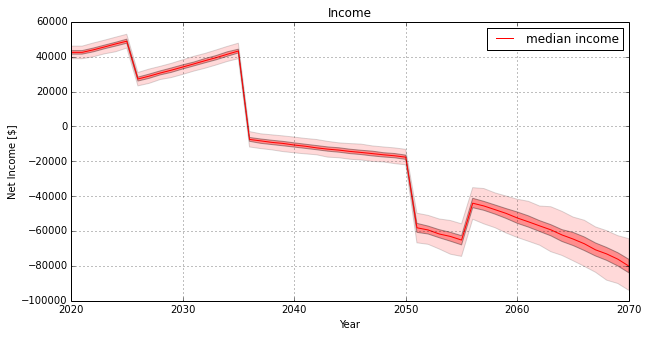

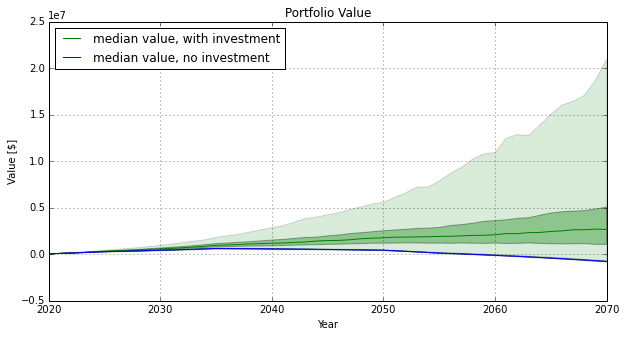

('median crossing, with investment: ', 2062)
('median crossing, no investment: ', 2057)


<function __main__.graph_update>

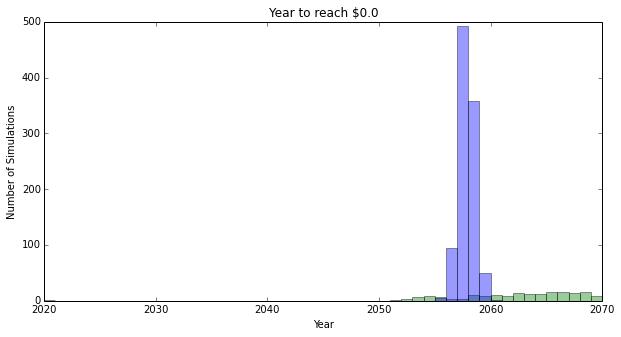

In [7]:
interact(
    graph_update,
    rate_of_return=widgets.FloatSlider(
        value=1.06,
        min=0.8,
        max=1.2,
        step=0.01),
    rate_of_return_stddev=widgets.FloatSlider(
        value=0.15,
        min=0.000001,
        max=0.2,
        step=0.01))